# Problem set-up

_It is suggested you first go over the reading material before you start here._

The problem with Quantum Computing Monte Carlo is the scaling of the state preparation. In this notebook, it is shown why there is a problem and you are pointed to some possible solutions.

## Probability distribution to load

### Problem Definition

We want to analyze the risk of a portfolio of $K$ assets.
The default probability of every asset $k$ follows a *Gaussian Conditional Independence* model, i.e., given a value $z$ sampled from a latent random variable $Z$ following a standard normal distribution, the default probability of asset $k$ is given by

$$p_k(z) = F\left( \frac{F^{-1}(p_k^0) - \sqrt{\rho_k}z}{\sqrt{1 - \rho_k}} \right) $$

where $F$ denotes the cumulative distribution function of $Z$, $p_k^0$ is the default probability of asset $k$ for $z=0$ and $\rho_k$ is the sensitivity of the default probability of asset $k$ with respect to $Z$. Thus, given a concrete realization of $Z$ the individual default events are assumed to be independent from each other.

We are interested in analyzing risk measures of the total loss

$$ L = \sum_{k=1}^K \lambda_k X_k(Z) $$

where $\lambda_k$ denotes the _loss given default_ of asset $k$, and given $Z$, $X_k(Z)$ denotes a Bernoulli variable representing the default event of asset $k$. More precisely, we are interested in the expected value $\mathbb{E}[L]$, the Value at Risk (VaR) of $L$ and the Conditional Value at Risk of $L$ (also called Expected Shortfall). Where VaR and CVaR are defined as

$$ \text{VaR}_{\alpha}(L) = \inf \{ x \mid \mathbb{P}[L <= x] \geq 1 - \alpha \}$$

with confidence level $\alpha \in [0, 1]$, and

$$ \text{CVaR}_{\alpha}(L) = \mathbb{E}[ L \mid L \geq \text{VaR}_{\alpha}(L) ].$$

For more details on the considered model, see, e.g.,<br>
[Regulatory Capital Modeling for Credit Risk. Marek Rutkowski, Silvio Tarca](https://arxiv.org/abs/1412.1183)



The problem is defined by the following parameters:

- the resolution of $Z$, given by $N_Z$
- number of qubits used to represent $Z$, denoted by $n_z=\lceil \log{N_Z} \rceil$
- truncation value for $Z$, denoted by $z_{\text{max}}$, i.e., Z is assumed to take $2^{n_z}$ equidistant values in $\{-z_{max}, ..., +z_{max}\}$ 
- the base default probabilities for each asset $p_0^k \in (0, 1)$, $k=1, ..., K$
- sensitivities of the default probabilities with respect to $Z$, denoted by $\rho_k \in [0, 1)$
- loss given default for asset $k$, denoted by $\lambda_k$
- confidence level for VaR / CVaR $\alpha \in [0, 1]$.


During this hackathon, the focus will be on the probability distribution loading part, not the VaR and CVaR calculation.

In [1]:
!pip install qiskit-finance pylatexenc perfplot

In [2]:
# imports
import numpy as np

In [3]:
# set problem parameters
N_z = 32
n_z = int(np.ceil(np.log2(N_z)))
z_max = 3
z_values = np.linspace(-z_max, z_max, 2**n_z)
p_zeros = [0.15, 0.25, 0.2, 0.1]
rhos = [0.1, 0.05, 0.15, 0.05]
lgd = [1, 2, 1, 3]
K = len(p_zeros)

## Qiskit implementation

Qiskit already has an implementation for this model. It is within [`qiskit_finance`](https://qiskit-community.github.io/qiskit-finance/). The implementation is imported below as `GCI`.

Let's take a closer look at that implementation.

In [4]:
import qiskit as q

# took from qiskit_finance.circuit.library
"""The Gaussian Conditional Independence Model for Credit Risk."""

from typing import List, Union
import numpy as np
from scipy.stats.distributions import norm

from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import LinearPauliRotations
from qiskit_finance.circuit.library.probability_distributions.normal import (
    NormalDistribution,
)


class GCI(q.QuantumCircuit):
    """The Gaussian Conditional Independence Model for Credit Risk.
    Reference: https://arxiv.org/abs/1412.1183
    Dependency between individual risk variables and latent variable is approximated linearly.
    """

    def __init__(
        self,
        n_normal: int,
        normal_max_value: float,
        p_zeros: Union[List[float], np.ndarray],
        rhos: Union[List[float], np.ndarray],
    ) -> None:
        """
        Args:
            n_normal: Number of qubits to represent the latent normal random variable Z
            normal_max_value: Min/max value to truncate the latent normal random variable Z
            p_zeros: Standard default probabilities for each asset
            rhos: Sensitivities of default probability of assets with respect to latent variable Z
        """
        self.n_normal = n_normal
        self.normal_max_value = normal_max_value
        self.p_zeros = p_zeros
        self.rhos = rhos
        num_qubits = n_normal + len(p_zeros)

        # get normal (inverse) CDF and pdf (these names are from the paper, therefore ignore
        # pylint)
        def F(x):  # pylint: disable=invalid-name
            return norm.cdf(x)

        def F_inv(x):  # pylint: disable=invalid-name
            return norm.ppf(x)

        def f(x):  # pylint: disable=invalid-name
            return norm.pdf(x)

        # create linear rotations for conditional defaults
        slopes = []
        offsets = []
        for rho, p_zero in zip(rhos, p_zeros):
            psi = F_inv(p_zero) / np.sqrt(1 - rho)

            # compute slope / offset
            slope = -np.sqrt(rho) / np.sqrt(1 - rho)
            slope *= f(psi) / np.sqrt(1 - F(psi)) / np.sqrt(F(psi))
            offset = 2 * np.arcsin(np.sqrt(F(psi)))

            # adjust for integer to normal range mapping
            offset += slope * (-normal_max_value)
            slope *= 2 * normal_max_value / (2**n_normal - 1)

            offsets += [offset]
            slopes += [slope]

        # create normal distribution
        normal_distribution = NormalDistribution(
            n_normal,
            0,
            1,
            bounds=(-normal_max_value, normal_max_value),
        )

        # build circuit
        inner = QuantumCircuit(num_qubits, name="P(X)")
        inner.append(normal_distribution.to_gate(), list(range(n_normal)))
        for k, (slope, offset) in enumerate(zip(slopes, offsets)):
            lry = LinearPauliRotations(n_normal, slope, offset)
            qubits = list(range(n_normal)) + [n_normal + k]
            inner.append(lry.to_gate(), qubits)

        super().__init__(num_qubits, name="P(X)")
        self.append(inner.to_gate(), inner.qubits)


# Create unitary
u = GCI(n_z, z_max, p_zeros, rhos)

# Draw the unitary (decomposed)
u.decompose().draw()

┌───────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q_0: ┤0      ├┤0        ├┤0        ├┤0        ├┤0        ├
     │       ││         ││         ││         ││         │
q_1: ┤1      ├┤1        ├┤1        ├┤1        ├┤1        ├
     │       ││         ││         ││         ││         │
q_2: ┤2 P(X) ├┤2        ├┤2        ├┤2        ├┤2        ├
     │       ││  LinRot ││         ││         ││         │
q_3: ┤3      ├┤3        ├┤3 LinRot ├┤3        ├┤3        ├
     │       ││         ││         ││  LinRot ││         │
q_4: ┤4      ├┤4        ├┤4        ├┤4        ├┤4 LinRot ├
     └───────┘│         ││         ││         ││         │
q_5: ─────────┤5        ├┤         ├┤         ├┤         ├
              └─────────┘│         ││         ││         │
q_6: ────────────────────┤5        ├┤         ├┤         ├
                         └─────────┘│         ││         │
q_7: ───────────────────────────────┤5        ├┤         ├
                                    └─────────┘│         │
q_8: ──────────────────────────────────────────┤5        ├
                                               └─────────┘

## Creating P(X)

The linear rotations are not that interesting for now. Let us inspect the `P(X)` part of the circuit.

In [14]:
# Create normal distribution
normal_distribution = NormalDistribution(
    3,
    0,
    1,
    bounds=(-z_max, z_max),
)

# Draw it
normal_distribution.draw()


┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1 P(X) ├
     │       │
q_2: ┤2      ├
     └───────┘

But what is inside? To find that out, we transpile the gate.

In [ ]:
# Define which basis gates to use
basis_gates = ["h", "ry", "cx", "p", "x", "s", "sdg", "y", "t"]

# Transpile the circuit
# normal_distribution.measure_all("meas")
normal_distribution_transpiled = q.transpile(normal_distribution, basis_gates=basis_gates)


def remove_specific_cx(circuit):
    modified_circuit = QuantumCircuit(*circuit.qregs, *circuit.cregs)
    
    # Mapping qubits to their indices for reference
    qubit_indices_map = {qubit: idx for idx, qubit in enumerate(circuit.qubits)}
    
    # Track whether the last gate on each qubit was Ry(0)
    last_ry_zero = {idx: False for idx in qubit_indices_map.values()}
    
    for instruction in circuit.data:
        gate, qubits, clbits = instruction
        qubit_indices = [qubit_indices_map[q] for q in qubits]
        
        # Check if the gate is an Ry gate with a parameter close to 0
        if gate.name == 'ry' and np.isclose(gate.params[0], 0.0, atol=1e-8):
            # Mark that the last Ry operation on this qubit was 0
            for q_index in qubit_indices:
                last_ry_zero[q_index] = True
        elif gate.name == 'cx':
            # If it's a CNOT, check if it should be skipped
            if any(last_ry_zero[q_index] for q_index in qubit_indices):
                # Reset the flags and skip this CNOT
                for q_index in qubit_indices:
                    last_ry_zero[q_index] = False
                continue
        else:
            # For all other gates, reset the flag
            for q_index in qubit_indices:
                last_ry_zero[q_index] = False

        # Append the gate to the modified circuit
        modified_circuit.append(gate, qubits, clbits)

    return modified_circuit



modified_circuit = remove_specific_cx(normal_distribution_transpiled)
normal_distribution_transpiled.draw("mpl")

As you can see, the number of controlled gates on the 2nd qubit (q3) is not that high (2), but then the number of controlled gates on the next qubit (q2) is already 4. q1 has 8 controlled gates and q0 has 16 controlled gates. I.e., the circuit depth scales exponential.

That is bad!

Quantum computers of today have many qubits ($O(100)$), but the qubits are not very good. Noise takes over quickly.

Let's see what that means.

57


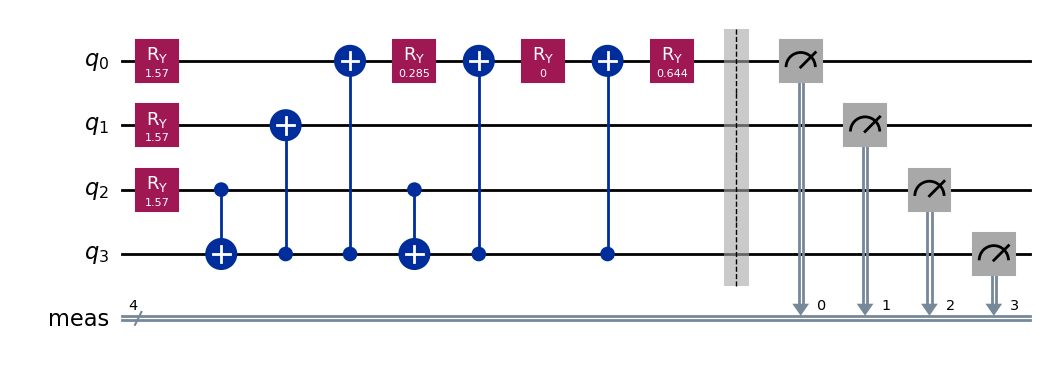

In [7]:
from qiskit import QuantumCircuit, QuantumRegister
# Define which basis gates to use
basis_gates = ["h", "ry", "cx", "p", "x", "s", "sdg", "y", "t"]

# Transpile the circuit
# normal_distribution.measure_all("meas")
normal_distribution_transpiled = q.transpile(normal_distribution, basis_gates=basis_gates)


def remove_specific_cx(circuit):
    modified_circuit = QuantumCircuit(*circuit.qregs, *circuit.cregs)
    
    # Mapping qubits to their indices for reference
    qubit_indices_map = {qubit: idx for idx, qubit in enumerate(circuit.qubits)}
    
    # Track whether the last gate on each qubit was Ry(0)
    last_ry_zero = {idx: False for idx in qubit_indices_map.values()}
    
    for instruction in circuit.data:
        gate, qubits, clbits = instruction
        qubit_indices = [qubit_indices_map[q] for q in qubits]
        
        # Check if the gate is an Ry gate with a parameter close to 0
        if gate.name == 'ry' and np.isclose(gate.params[0], 0.0, atol=1e-8):
            # Mark that the last Ry operation on this qubit was 0
            for q_index in qubit_indices:
                last_ry_zero[q_index] = True
        elif gate.name == 'cx':
            # If it's a CNOT, check if it should be skipped
            if any(last_ry_zero[q_index] for q_index in qubit_indices):
                # Reset the flags and skip this CNOT
                for q_index in qubit_indices:
                    last_ry_zero[q_index] = False
                continue
        else:
            # For all other gates, reset the flag
            for q_index in qubit_indices:
                last_ry_zero[q_index] = False

        # Append the gate to the modified circuit
        modified_circuit.append(gate, qubits, clbits)

    return modified_circuit



modified_circuit = remove_specific_cx(normal_distribution_transpiled)
# Define a quantum register with 4 qubits: 3 original + 1 ancilla
qr = QuantumRegister(4, 'q')
circuit = QuantumCircuit(qr)

# Initial state preparations
circuit.ry(1.5708, qr[2])  # Apply RY to the control qubit (used as example)
circuit.ry(1.5708, qr[1])
circuit.ry(1.5708, qr[0])

# Copy control qubit state (qr[2]) to ancilla (qr[3])
circuit.cx(qr[2], qr[3])

# Use the ancilla (qr[3]) to perform CNOT operations
circuit.cx(qr[3], qr[1])
circuit.cx(qr[3], qr[0])

# Optional: Reset the ancilla if it will be reused
circuit.cx(qr[2], qr[3])  # This uncomputes the ancilla, setting it back to initial state

# Continue with further operations if needed
circuit.ry(0.285, qr[0])
circuit.cx(qr[3], qr[0])
circuit.ry(1.665e-16, qr[0])
circuit.cx(qr[3], qr[0])
circuit.ry(0.644, qr[0])

normal_distribution = circuit
normal_distribution.measure_all()
#normal_distribution_transpiled.draw("mpl")
print(normal_distribution_transpiled.depth())
normal_distribution.draw("mpl")

## Running on a noisy simulator

In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

# Run the sampler job locally using FakeManilaV2
fake_manila = FakeManilaV2()
pm = generate_preset_pass_manager(backend=fake_manila, optimization_level=1)
qc_trans_manilla = pm.run(normal_distribution)

noisy_simulator = AerSimulator.from_backend(fake_manila)
results_noisy = noisy_simulator.run(qc_trans_manilla, shots=8192).result()

# Run the circuit locally using an exact simulator
# This is for testing purposes
aer_sim = AerSimulator()
qc_trans_aer = q.transpile(normal_distribution, aer_sim)

results_exact = aer_sim.run(qc_trans_aer, shots=10e6).result()

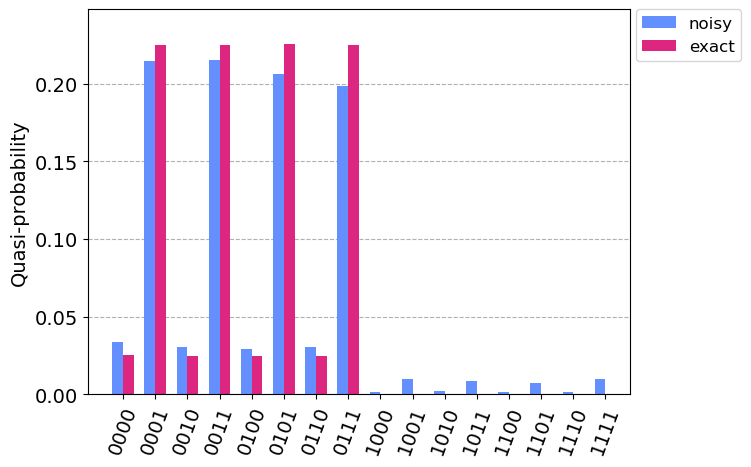

In [9]:
from qiskit.visualization import plot_distribution

# Get the counts
counts_noisy = results_noisy.get_counts(0)
counts_exact = results_exact.get_counts(0)

# Now plot the results
plot_distribution(
    [counts_noisy, counts_exact], legend=["noisy", "exact"], bar_labels=False
)

Now the noisy simulator results do not look like a Gaussian to me.

That is because the circuits are too deep.

## Scaling analysis

Let see how that scales.

In [10]:
# import perfplot


# Create a wrapper function for the qiskit implementation
def qiskit_normal_distribution(N_z):
    n_z = int(np.ceil(np.log2(N_z)))
    normal_distribution = NormalDistribution(n_z, 0, 1, (-z_max, z_max))

    print(f" Normalized circuit depth is {get_circuit_depth(normal_distribution)}")
    normal_distribution.draw("mpl")
    
    normal_distribution2 = remove_specific_cx(normal_distribution)

    print(f"Our circuit depth is {normal_distribution2.depth()}")
    normal_distribution2.draw("mpl")

    return normal_distribution2


# Create a wrapper function that calculates the circuit depth
def get_circuit_depth(qc):
    qc_transpiled = q.transpile(qc, basis_gates=basis_gates)
    return qc_transpiled.depth()

 Normalized circuit depth is 1
Our circuit depth is 1
 Normalized circuit depth is 4
Our circuit depth is 1
 Normalized circuit depth is 11
Our circuit depth is 1
 Normalized circuit depth is 26
Our circuit depth is 1
 Normalized circuit depth is 57
Our circuit depth is 1
 Normalized circuit depth is 120
Our circuit depth is 1
 Normalized circuit depth is 247
Our circuit depth is 1
 Normalized circuit depth is 502
Our circuit depth is 1
 Normalized circuit depth is 1013
Our circuit depth is 1
 Normalized circuit depth is 2036
Our circuit depth is 1
 Normalized circuit depth is 4083
Our circuit depth is 1
 Normalized circuit depth is 8178
Our circuit depth is 1


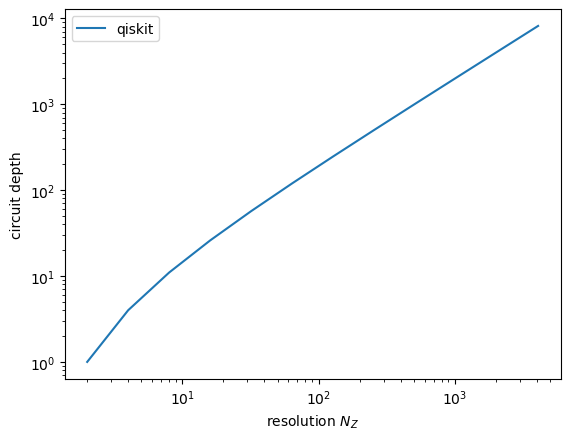

In [11]:
import matplotlib.pyplot as plt

plt.style.use("default")

# Create a plot of the circuit depth vs. number of qubits

# Set the number of qubits
x = np.logspace(1, 12, 12, base=2, dtype=int)

# Get the circuit depth for qiskit implementation
y_qiskit = [get_circuit_depth(qiskit_normal_distribution(int(n))) for n in x]
plt.plot(x, y_qiskit, label="qiskit")

# Any other implementations go here

# Show the plot
plt.xlabel("resolution $N_Z$")
plt.ylabel("circuit depth")

plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.show()

# Hackathon challenge

Your challenge is not to create a distribution loading method that can load distributions sub-exponential. That would be too much to ask (although it would be cool 😉).

The challenge is to change the distribution loading of qiskit in such a way that the circuit depth is lower. Probably, you will need extra (ancilla) qubits for this, but that is no big issue, as quantum computers in the NISQ-era tend to have many physical qubits with low error rate. Error rate and noise are our enemies in this challenge, not the small size of the QPU's.

When you have created a good distribution loading method, apply your new method to the credit risk analysis example. See if you can get to better accuracies than the qiskit implementation.

Additionally, consider integrating the Quantinuum H-series systems into your analysis. For this challenge, the H1-1 emulator is available through Quantinuum Nexus for exploration. The H-series platforms could offer significant advantages in terms of error rates due to the system's high-fidelity qubits.

## Running on H-Series Emulators

First convert Qiskit circuit to `pytket` circuit

In [12]:
from pytket.extensions.qiskit import qiskit_to_tk
from pytket.circuit.display import render_circuit_jupyter

tket_circuit = qiskit_to_tk(normal_distribution)
render_circuit_jupyter(tket_circuit)